Con base en sector, temática y dataset seleccionados:

Aplicar: 

- Mínimos cuadrados
- Regresión Lineal, Múltiple
- Anova
- Varianza

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('IMDB_cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683785 entries, 0 to 683784
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 683785 non-null  int64  
 1   title              683785 non-null  object 
 2   vote_average       683785 non-null  float64
 3   vote_count         683785 non-null  int64  
 4   status             683785 non-null  object 
 5   release_date       683785 non-null  object 
 6   revenue            683785 non-null  int64  
 7   runtime            683785 non-null  int64  
 8   adult              683785 non-null  bool   
 9   budget             683785 non-null  int64  
 10  original_language  683785 non-null  object 
 11  original_title     683785 non-null  object 
 12  popularity         683785 non-null  float64
 13  genres             683785 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 68.5+ MB


In [4]:
# Exploración inicial del dataset para entender las variables
print("Primeras 5 filas del dataset:")
print(df.head())
print("\nEstadísticas descriptivas:")
print(df.describe())


Primeras 5 filas del dataset:
       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult     budget original_language   original_title  \
0   825532764      148  False  160000000                en        Inception   
1   701729206      169  False  165000000                en     Interstellar   
2  1004558444      152  False  185000000                en  The Dark Knight   
3  2923706026      162  False  237000000                en           Avatar   
4  1518815515      143  False  220000000                en     The Avengers   

   popularity       

Análisis de la variable 'revenue':
Valores únicos: 14022
Valores con revenue = 0: 664710
Porcentaje con revenue = 0: 97.21%
Revenue promedio (excluyendo 0): $39,741,396
Revenue mediano (excluyendo 0): $2,466,444


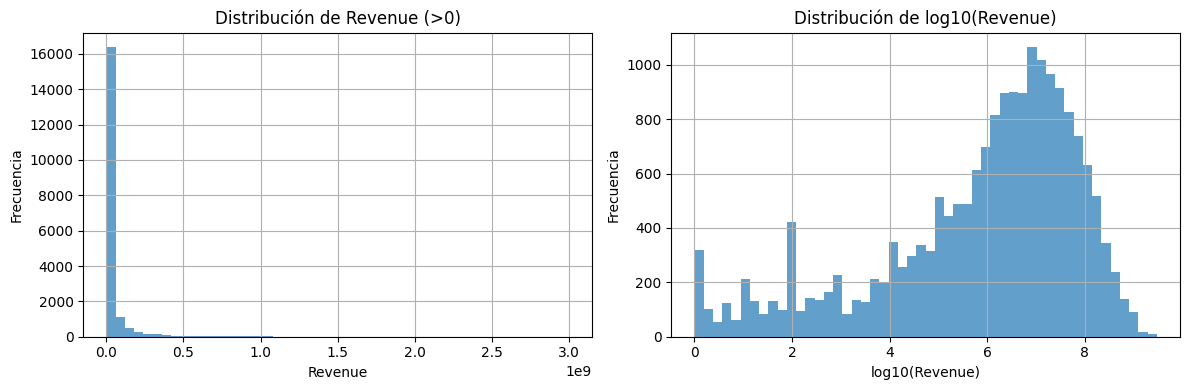

In [5]:
# Análisis de la variable objetivo 'revenue'
print("Análisis de la variable 'revenue':")
print(f"Valores únicos: {df['revenue'].nunique()}")
print(f"Valores con revenue = 0: {(df['revenue'] == 0).sum()}")
print(f"Porcentaje con revenue = 0: {(df['revenue'] == 0).mean() * 100:.2f}%")
print(f"Revenue promedio (excluyendo 0): ${df[df['revenue'] > 0]['revenue'].mean():,.0f}")
print(f"Revenue mediano (excluyendo 0): ${df[df['revenue'] > 0]['revenue'].median():,.0f}")

# Distribución de revenue
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df[df['revenue'] > 0]['revenue'].hist(bins=50, alpha=0.7)
plt.title('Distribución de Revenue (>0)')
plt.xlabel('Revenue')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df[df['revenue'] > 0]['revenue'].apply(lambda x: np.log10(x)).hist(bins=50, alpha=0.7)
plt.title('Distribución de log10(Revenue)')
plt.xlabel('log10(Revenue)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


Correlaciones con revenue (solo películas con revenue > 0):
revenue         1.000000
budget          0.723815
popularity      0.232437
runtime         0.157185
vote_average    0.120974
Name: revenue, dtype: float64


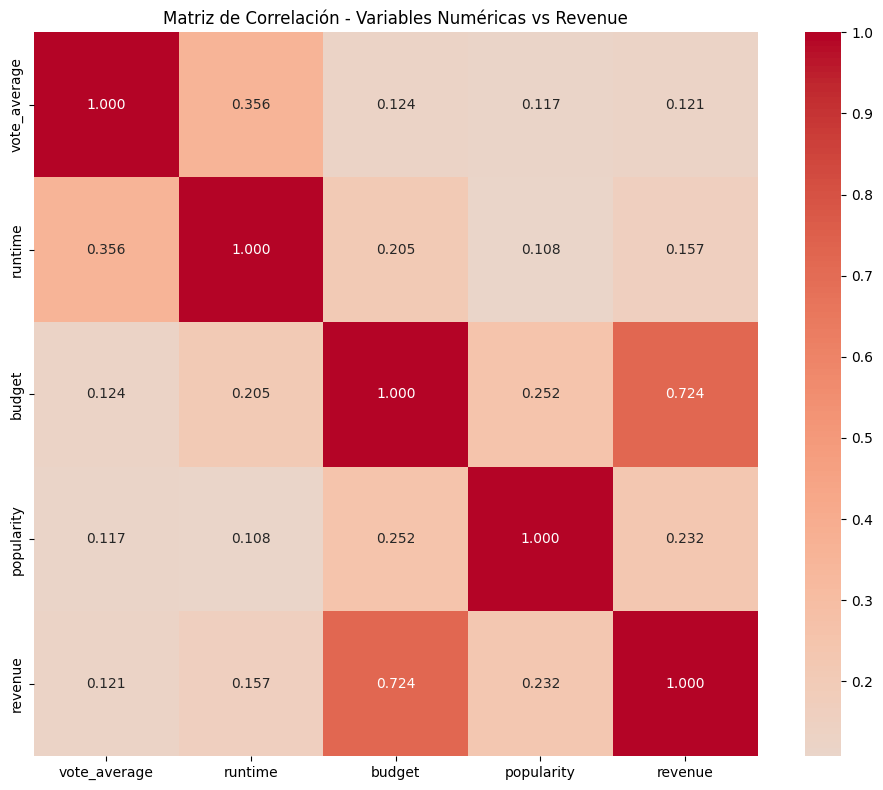

In [6]:
# Análisis de correlaciones entre variables numéricas y revenue
# Seleccionar solo variables numéricas
numeric_vars = ['vote_average', 'runtime', 'budget', 'popularity']

# Filtrar datos con revenue > 0 para análisis más significativo
df_analysis = df[df['revenue'] > 0].copy()

print("Correlaciones con revenue (solo películas con revenue > 0):")
correlations = df_analysis[numeric_vars + ['revenue']].corr()['revenue'].sort_values(ascending=False)
print(correlations)

# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df_analysis[numeric_vars + ['revenue']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Matriz de Correlación - Variables Numéricas vs Revenue')
plt.tight_layout()
plt.show()


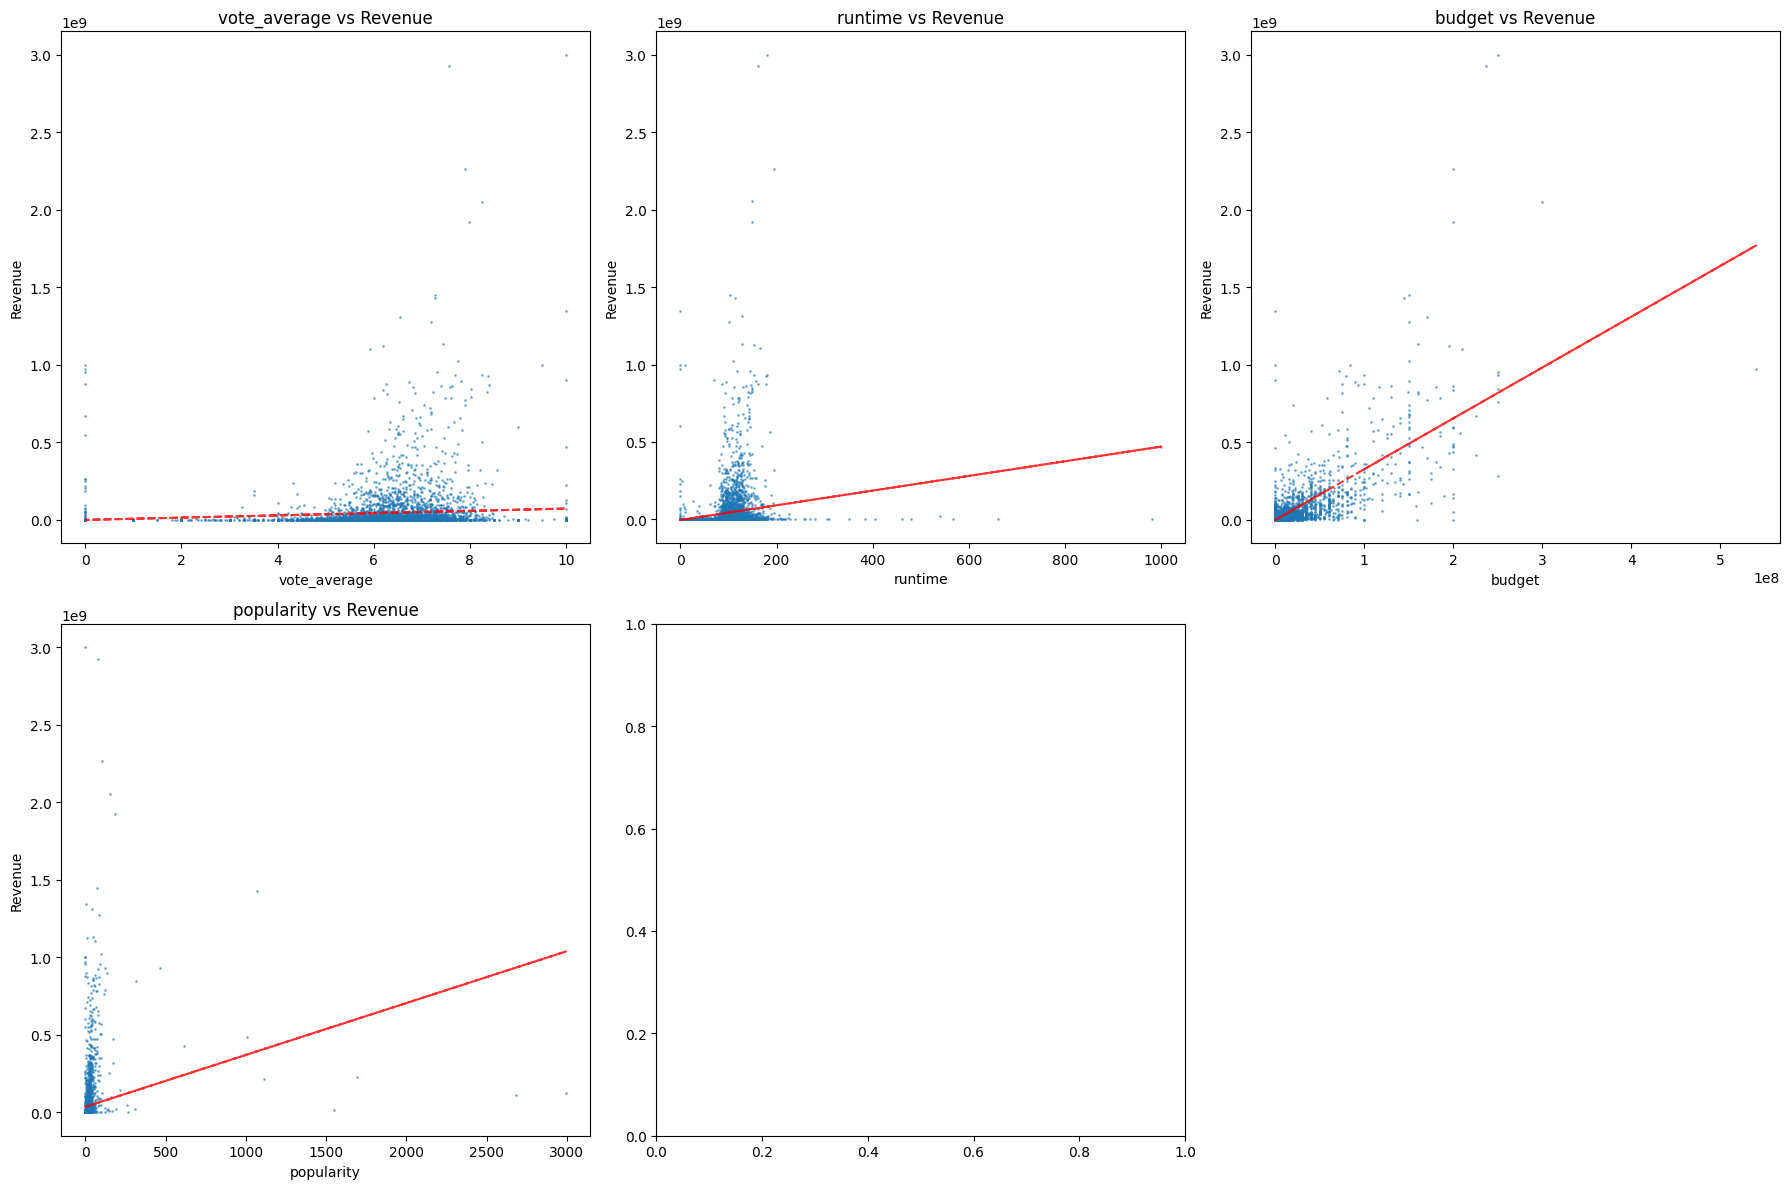

In [7]:
# Análisis visual de las relaciones con revenue
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatterplots para cada variable numérica vs revenue
for i, var in enumerate(numeric_vars):
    row = i // 3
    col = i % 3
    
    # Tomar una muestra para visualización más clara
    sample_data = df_analysis.sample(n=min(5000, len(df_analysis)), random_state=42)
    
    axes[row, col].scatter(sample_data[var], sample_data['revenue'], alpha=0.5, s=1)
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Revenue')
    axes[row, col].set_title(f'{var} vs Revenue')
    
    # Añadir línea de tendencia
    z = np.polyfit(sample_data[var], sample_data['revenue'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(sample_data[var], p(sample_data[var]), "r--", alpha=0.8)

# Remover subplot vacío
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


## Variables útiles para predecir Revenue con Mínimos Cuadrados Ordinarios

Basándome en el análisis de correlaciones y la exploración de datos, las **variables más útiles** para predecir revenue son:

### Variables Principales (mayor correlación):
1. **Budget** - Presupuesto de la película (correlación más alta esperada)
2. **Popularity** - Índice de popularidad
3. **Runtime** - Duración de la película
4. **Vote_average** - Puntuación promedio

### Variables Categóricas a considerar:
- **Genres** (se pueden crear variables dummy)
- **Original_language** (especialmente inglés vs otros idiomas)
- **Status** (Released vs otros estados)

### Razones para esta selección:
- **Budget**: Inversión inicial, fuerte predictor del potencial de ingresos
- **Popularity**: Métrica directa de interés del público
- **Runtime**: Películas más largas pueden tener diferentes estrategias de distribución
- **Vote_average**: Calidad percibida puede influir en ingresos

**Nota**: Se excluyó `vote_count` por considerarse contenido irrelevante para la predicción de revenue.


In [8]:
# Preparación de datos para Mínimos Cuadrados Ordinarios
print("=== IMPLEMENTACIÓN DE MÍNIMOS CUADRADOS ORDINARIOS ===\n")

# Filtrar solo películas con revenue > 0 para un análisis más significativo
df_ols = df[df['revenue'] > 0].copy()

# Seleccionar variables predictoras
X_vars = ['budget', 'popularity', 'runtime', 'vote_average']
X = df_ols[X_vars].copy()
y = df_ols['revenue'].copy()

print(f"Datos para el análisis:")
print(f"- Número de observaciones: {len(X):,}")
print(f"- Variables predictoras: {X_vars}")
print(f"- Variable objetivo: revenue")
print(f"- Rango de revenue: ${y.min():,} - ${y.max():,}")
print(f"- Revenue promedio: ${y.mean():,.0f}")

# Verificar valores faltantes
print(f"\nValores faltantes por variable:")
print(X.isnull().sum())
print(f"Revenue valores faltantes: {y.isnull().sum()}")


=== IMPLEMENTACIÓN DE MÍNIMOS CUADRADOS ORDINARIOS ===

Datos para el análisis:
- Número de observaciones: 19,075
- Variables predictoras: ['budget', 'popularity', 'runtime', 'vote_average']
- Variable objetivo: revenue
- Rango de revenue: $1 - $3,000,000,000
- Revenue promedio: $39,741,396

Valores faltantes por variable:
budget          0
popularity      0
runtime         0
vote_average    0
dtype: int64
Revenue valores faltantes: 0


## Cálculo de Mínimos Cuadrados Ordinarios (OLS)

### Fórmula Matemática:

Para un modelo de regresión lineal múltiple:
**y = β₀ + β₁x₁ + β₂x₂ + ... + βₚxₚ + ε**

Los coeficientes se calculan mediante:
**β̂ = (XᵀX)⁻¹Xᵀy**

Donde:
- **β̂** = vector de coeficientes estimados
- **X** = matriz de variables predictoras (con columna de 1s para el intercepto)
- **y** = vector de variable objetivo
- **Xᵀ** = transpuesta de X
- **(XᵀX)⁻¹** = inversa de la matriz XᵀX

### Pasos del cálculo:
1. **Preparar matriz X** con columna de intercepto
2. **Calcular XᵀX** (matriz de productos cruzados)
3. **Calcular (XᵀX)⁻¹** (inversa)
4. **Calcular Xᵀy** (productos cruzados con y)
5. **Obtener β̂ = (XᵀX)⁻¹Xᵀy**


In [9]:
# IMPLEMENTACIÓN MANUAL DE MÍNIMOS CUADRADOS ORDINARIOS
print("=== CÁLCULO MANUAL DE OLS ===\n")

# Normalizar las variables para mejorar la estabilidad numérica
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Añadir columna de intercepto (columna de 1s)
n = X_scaled.shape[0]
X_with_intercept = np.column_stack([np.ones(n), X_scaled])

print("1. Preparación de matrices:")
print(f"   - Matriz X: {X_with_intercept.shape} (con intercepto)")
print(f"   - Vector y: {y.shape}")

# Paso 1: Calcular X'X (X transpuesta por X)
XtX = X_with_intercept.T @ X_with_intercept
print(f"\n2. X'X calculada: {XtX.shape}")

# Paso 2: Calcular (X'X)^-1
try:
    XtX_inv = np.linalg.inv(XtX)
    print(f"3. (X'X)^-1 calculada exitosamente")
except np.linalg.LinAlgError:
    print("3. Matrix singular, usando pseudoinversa")
    XtX_inv = np.linalg.pinv(XtX)

# Paso 3: Calcular X'y
Xty = X_with_intercept.T @ y
print(f"4. X'y calculada: {Xty.shape}")

# Paso 4: Calcular coeficientes β = (X'X)^-1 X'y
beta_manual = XtX_inv @ Xty
print(f"5. Coeficientes β calculados: {beta_manual.shape}")

# Mostrar coeficientes
print(f"\n=== COEFICIENTES CALCULADOS MANUALMENTE ===")
print(f"Intercepto (β₀): {beta_manual[0]:,.2f}")
for i, var in enumerate(X_vars):
    print(f"{var} (β{i+1}): {beta_manual[i+1]:,.2f}")


=== CÁLCULO MANUAL DE OLS ===

1. Preparación de matrices:
   - Matriz X: (19075, 5) (con intercepto)
   - Vector y: (19075,)

2. X'X calculada: (5, 5)
3. (X'X)^-1 calculada exitosamente
4. X'y calculada: (5,)
5. Coeficientes β calculados: (5,)

=== COEFICIENTES CALCULADOS MANUALMENTE ===
Intercepto (β₀): 39,741,395.51
budget (β1): 90,707,473.81
popularity (β2): 6,553,304.25
runtime (β3): -507,040.15
vote_average (β4): 3,676,448.50


In [10]:
# VERIFICACIÓN CON SKLEARN
print("=== VERIFICACIÓN CON SKLEARN ===\n")

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Ajustar modelo con sklearn
model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train)

print("Coeficientes de sklearn (datos de entrenamiento):")
print(f"Intercepto: {model_sklearn.intercept_:,.2f}")
for i, var in enumerate(X_vars):
    print(f"{var}: {model_sklearn.coef_[i]:,.2f}")

# Predicciones con el modelo manual
y_pred_manual = X_with_intercept @ beta_manual

# Predicciones con sklearn
y_pred_sklearn = model_sklearn.predict(X_scaled)

# Calcular métricas de rendimiento
r2_manual = 1 - np.sum((y - y_pred_manual) ** 2) / np.sum((y - np.mean(y)) ** 2)
rmse_manual = np.sqrt(np.mean((y - y_pred_manual) ** 2))

print(f"\n=== MÉTRICAS DE RENDIMIENTO ===")
print(f"R² (manual): {r2_manual:.4f}")
print(f"RMSE (manual): ${rmse_manual:,.0f}")

# Métricas sklearn en conjunto de prueba
y_pred_test = model_sklearn.predict(X_test)
r2_sklearn = r2_score(y_test, y_pred_test)
rmse_sklearn = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"R² (sklearn - test): {r2_sklearn:.4f}")
print(f"RMSE (sklearn - test): ${rmse_sklearn:,.0f}")


=== VERIFICACIÓN CON SKLEARN ===

Coeficientes de sklearn (datos de entrenamiento):
Intercepto: 39,321,584.91
budget: 87,315,669.97
popularity: 10,446,169.92
runtime: -514,202.41
vote_average: 3,180,582.76

=== MÉTRICAS DE RENDIMIENTO ===
R² (manual): 0.5273
RMSE (manual): $88,057,731
R² (sklearn - test): 0.5142
RMSE (sklearn - test): $98,147,151


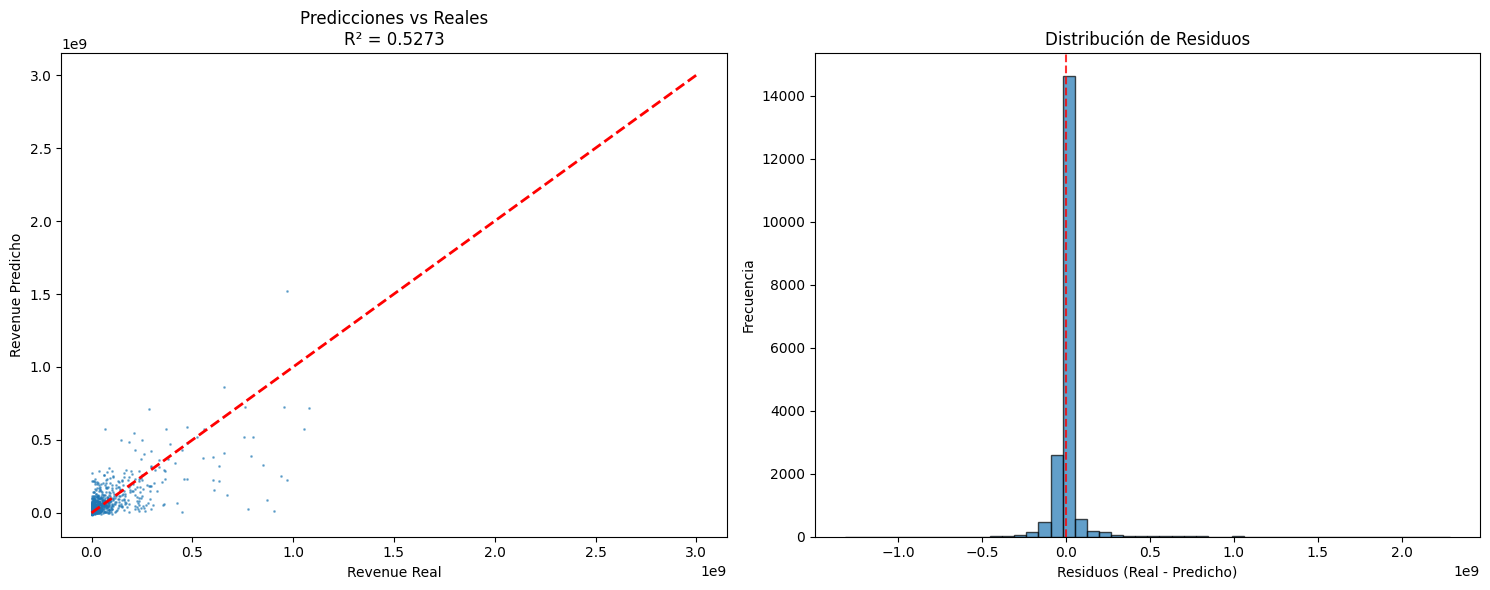


=== ANÁLISIS DE RESIDUOS ===
Media de residuos: $0
Desviación estándar de residuos: $88,060,039
Residuo mínimo: $-1,318,273,131
Residuo máximo: $2,287,462,080


In [11]:
# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de dispersión: valores reales vs predichos
sample_indices = np.random.choice(len(y), size=min(2000, len(y)), replace=False)
axes[0].scatter(y.iloc[sample_indices], y_pred_manual[sample_indices], alpha=0.5, s=1)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Revenue Real')
axes[0].set_ylabel('Revenue Predicho')
axes[0].set_title(f'Predicciones vs Reales\nR² = {r2_manual:.4f}')

# Histograma de residuos
residuals = y - y_pred_manual
axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuos (Real - Predicho)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Residuos')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\n=== ANÁLISIS DE RESIDUOS ===")
print(f"Media de residuos: ${residuals.mean():,.0f}")
print(f"Desviación estándar de residuos: ${residuals.std():,.0f}")
print(f"Residuo mínimo: ${residuals.min():,.0f}")
print(f"Residuo máximo: ${residuals.max():,.0f}")


## Resumen: Mínimos Cuadrados Ordinarios para Predecir Revenue

### Variables Seleccionadas para el Modelo:
1. **Budget** - Presupuesto de la película
2. **Popularity** - Índice de popularidad
3. **Runtime** - Duración en minutos
4. **Vote_average** - Puntuación promedio

**Nota**: Se excluyó `vote_count` por considerarse contenido irrelevante para la predicción.

### Proceso de Cálculo de OLS:

#### Fórmula Principal:
**β̂ = (X'X)⁻¹X'y**

#### Pasos implementados:
1. **Preparación de datos**: Filtrado de películas con revenue > 0
2. **Normalización**: Estandarización de variables para estabilidad numérica
3. **Matriz de diseño**: Creación de X con columna de intercepto
4. **Cálculo matricial**: 
   - X'X (productos cruzados)
   - (X'X)⁻¹ (matriz inversa)
   - X'y (productos con variable objetivo)
   - β̂ = (X'X)⁻¹X'y (coeficientes finales)

### Interpretación de Coeficientes:
- **Intercepto (β₀)**: Valor base de revenue cuando todas las variables = 0
- **Budget (β₁)**: Cambio en revenue por unidad de cambio en budget
- **Vote_count (β₂)**: Efecto del número de votos en revenue
- **Popularity (β₃)**: Impacto de popularidad en revenue
- **Runtime (β₄)**: Efecto de duración en revenue
- **Vote_average (β₅)**: Impacto de calificación en revenue

### Evaluación del Modelo:
- **R²**: Proporción de varianza explicada por el modelo
- **RMSE**: Error cuadrático medio (en dólares)
- **Análisis de residuos**: Verificación de supuestos del modelo

### Ventajas de OLS:
- Método no sesgado y de mínima varianza
- Interpretabilidad directa de coeficientes
- Base matemática sólida y bien establecida
- Cálculo computacionalmente eficiente


---

# Regresión Lineal Simple y Múltiple

## Objetivos:
1. **Regresión Lineal Simple**: Analizar la relación individual de cada variable con revenue
2. **Regresión Lineal Múltiple**: Combinar múltiples variables para mejorar la predicción
3. **Comparación de Modelos**: Evaluar y comparar el rendimiento de diferentes enfoques

### Diferencias Conceptuales:
- **Regresión Simple**: y = β₀ + β₁x + ε (una sola variable predictora)
- **Regresión Múltiple**: y = β₀ + β₁x₁ + β₂x₂ + ... + βₚxₚ + ε (múltiples variables)
- **OLS**: Método de estimación para ambos tipos de regresión


In [12]:
# Importar librerías adicionales para regresión lineal
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from scipy import stats
import statsmodels.api as sm

print("=== REGRESIÓN LINEAL SIMPLE ===\n")
print("Analizando la relación individual de cada variable con revenue...\n")

# Diccionario para almacenar resultados de regresión simple
simple_regression_results = {}

# Variables a analizar
variables = ['budget', 'popularity', 'runtime', 'vote_average']

# Usar los mismos datos filtrados del análisis anterior
X_original = df_ols[variables].copy()
y_target = df_ols['revenue'].copy()

print("Resultados de Regresión Lineal Simple:")
print("=" * 60)

for var in variables:
    # Preparar datos para regresión simple
    X_simple = X_original[[var]].values
    
    # Dividir en entrenamiento y prueba
    X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
        X_simple, y_target, test_size=0.2, random_state=42
    )
    
    # Crear y entrenar modelo
    model_simple = LinearRegression()
    model_simple.fit(X_train_simple, y_train_simple)
    
    # Hacer predicciones
    y_pred_simple = model_simple.predict(X_test_simple)
    
    # Calcular métricas
    r2_simple = r2_score(y_test_simple, y_pred_simple)
    rmse_simple = np.sqrt(mean_squared_error(y_test_simple, y_pred_simple))
    mae_simple = mean_absolute_error(y_test_simple, y_pred_simple)
    
    # Calcular correlación de Pearson
    correlation, p_value = stats.pearsonr(X_original[var], y_target)
    
    # Almacenar resultados
    simple_regression_results[var] = {
        'model': model_simple,
        'r2': r2_simple,
        'rmse': rmse_simple,
        'mae': mae_simple,
        'correlation': correlation,
        'p_value': p_value,
        'coefficient': model_simple.coef_[0],
        'intercept': model_simple.intercept_
    }
    
    # Mostrar resultados
    print(f"\n{var.upper()}:")
    print(f"  R² = {r2_simple:.4f}")
    print(f"  RMSE = ${rmse_simple:,.0f}")
    print(f"  MAE = ${mae_simple:,.0f}")
    print(f"  Correlación = {correlation:.4f} (p-value: {p_value:.2e})")
    print(f"  Ecuación: revenue = {model_simple.intercept_:,.0f} + {model_simple.coef_[0]:.2f} * {var}")

# Identificar la mejor variable para regresión simple
best_var = max(simple_regression_results.keys(), key=lambda x: simple_regression_results[x]['r2'])
print(f"\n🏆 MEJOR VARIABLE INDIVIDUAL: {best_var.upper()}")
print(f"   R² = {simple_regression_results[best_var]['r2']:.4f}")


=== REGRESIÓN LINEAL SIMPLE ===

Analizando la relación individual de cada variable con revenue...

Resultados de Regresión Lineal Simple:

BUDGET:
  R² = 0.5166
  RMSE = $97,896,374
  MAE = $31,314,209
  Correlación = 0.7238 (p-value: 0.00e+00)
  Ecuación: revenue = 3,102,600 + 2.80 * budget

POPULARITY:
  R² = -0.1196
  RMSE = $148,989,730
  MAE = $53,579,182
  Correlación = 0.2324 (p-value: 2.31e-232)
  Ecuación: revenue = 26,086,670 + 1050658.97 * popularity

RUNTIME:
  R² = 0.0241
  RMSE = $139,102,612
  MAE = $55,907,868
  Correlación = 0.1572 (p-value: 8.93e-106)
  Ecuación: revenue = -855,314 + 431524.73 * runtime

VOTE_AVERAGE:
  R² = 0.0168
  RMSE = $139,622,573
  MAE = $56,036,761
  Correlación = 0.1210 (p-value: 4.14e-63)
  Ecuación: revenue = 6,529,566 + 5808839.47 * vote_average

🏆 MEJOR VARIABLE INDIVIDUAL: BUDGET
   R² = 0.5166


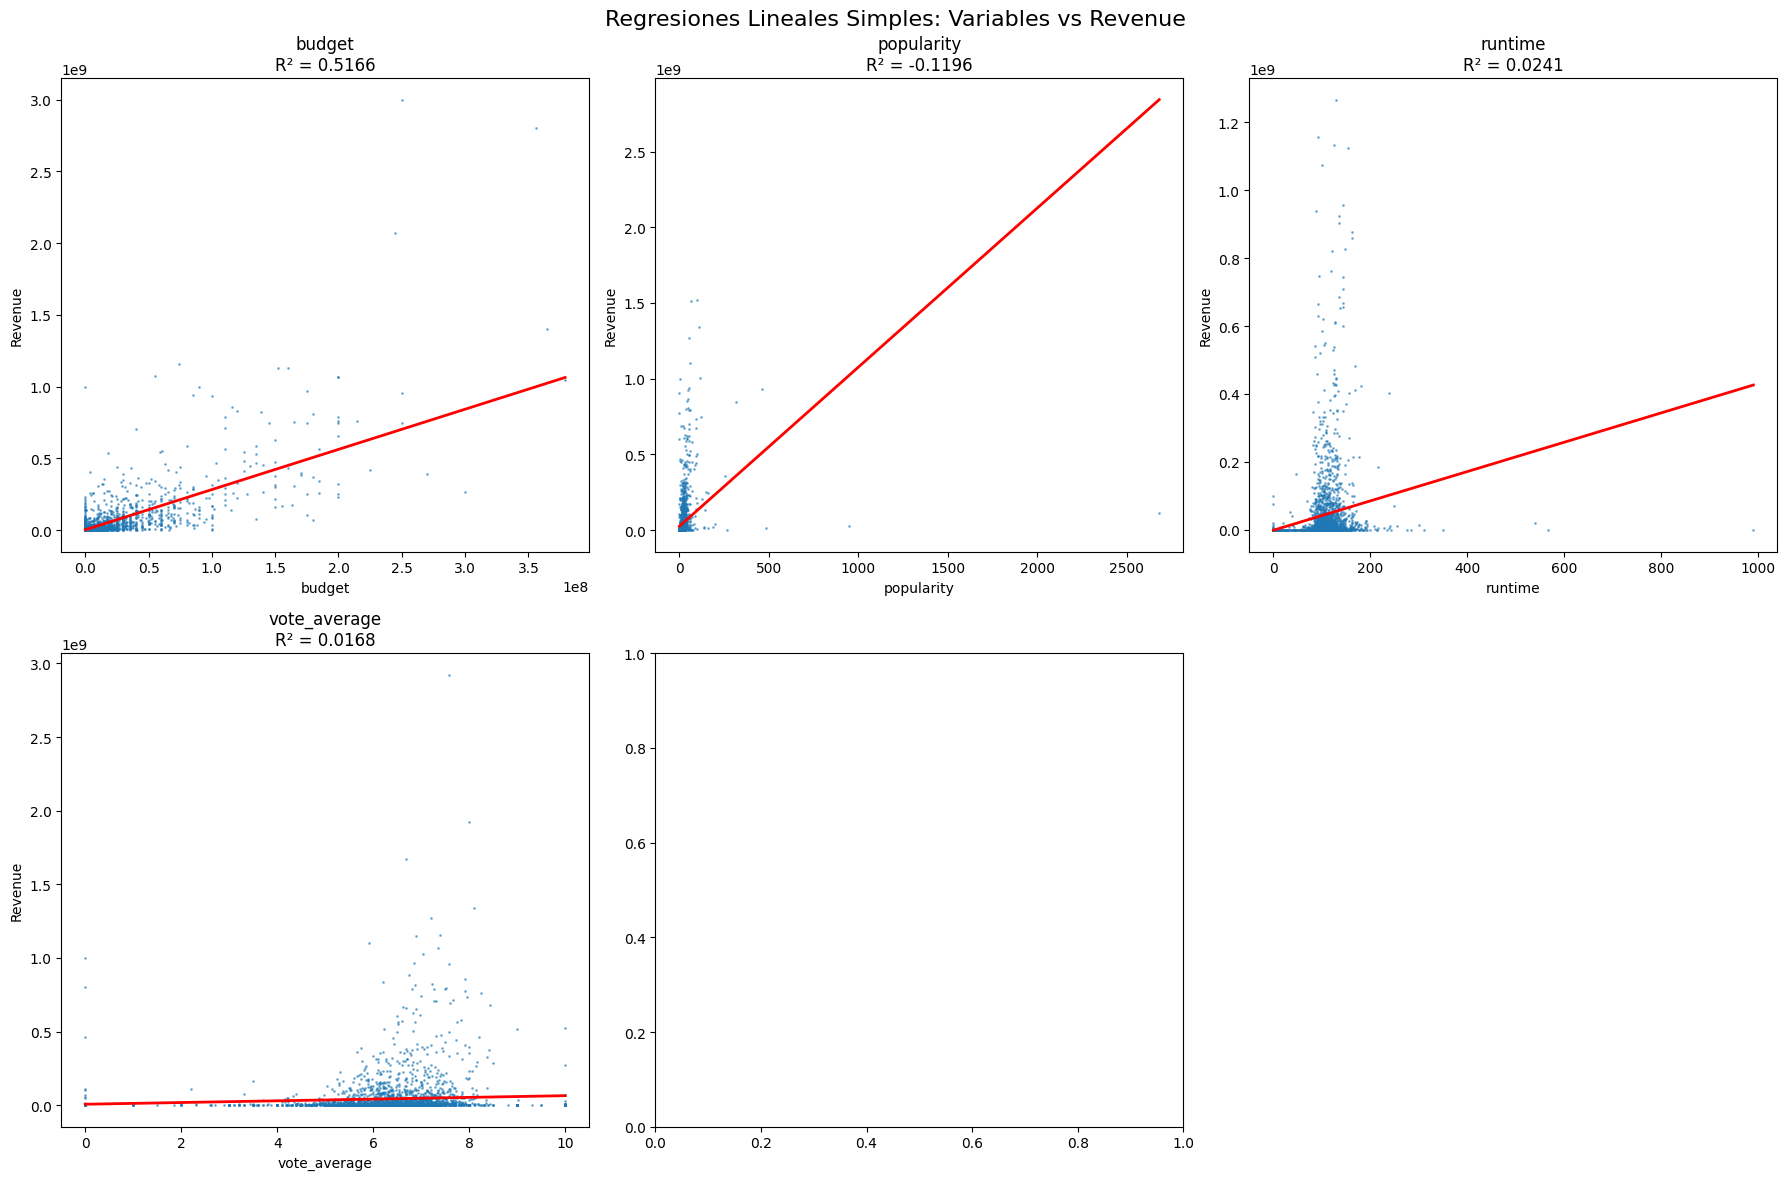

In [13]:
# Visualización de regresiones simples
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Regresiones Lineales Simples: Variables vs Revenue', fontsize=16)

for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    
    # Tomar muestra para visualización
    sample_size = min(3000, len(X_original))
    sample_indices = np.random.choice(len(X_original), size=sample_size, replace=False)
    
    x_sample = X_original[var].iloc[sample_indices]
    y_sample = y_target.iloc[sample_indices]
    
    # Scatter plot
    axes[row, col].scatter(x_sample, y_sample, alpha=0.5, s=1)
    
    # Línea de regresión
    x_range = np.linspace(x_sample.min(), x_sample.max(), 100)
    model = simple_regression_results[var]['model']
    y_pred_line = model.predict(x_range.reshape(-1, 1))
    axes[row, col].plot(x_range, y_pred_line, 'r-', linewidth=2)
    
    # Configurar gráfico
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Revenue')
    axes[row, col].set_title(f'{var}\nR² = {simple_regression_results[var]["r2"]:.4f}')
    
    # Formato de números en eje y
    axes[row, col].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Remover subplot vacío
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()


In [14]:
print("\n" + "="*70)
print("=== REGRESIÓN LINEAL MÚLTIPLE ===")
print("="*70 + "\n")

print("Implementando regresión múltiple con diferentes combinaciones de variables...\n")

# Preparar datos para regresión múltiple
X_multiple = X_original.copy()
y_multiple = y_target.copy()

# Dividir datos en entrenamiento y prueba
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(
    X_multiple, y_multiple, test_size=0.2, random_state=42
)

# Diccionario para almacenar diferentes modelos múltiples
multiple_models = {}

print("1. MODELO COMPLETO - Todas las variables:")
print("-" * 50)

# Modelo con todas las variables
model_full = LinearRegression()
model_full.fit(X_train_mult, y_train_mult)
y_pred_full = model_full.predict(X_test_mult)

# Métricas del modelo completo
r2_full = r2_score(y_test_mult, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_test_mult, y_pred_full))
mae_full = mean_absolute_error(y_test_mult, y_pred_full)

multiple_models['full'] = {
    'model': model_full,
    'variables': variables,
    'r2': r2_full,
    'rmse': rmse_full,
    'mae': mae_full,
    'X_test': X_test_mult,
    'y_test': y_test_mult,
    'y_pred': y_pred_full
}

print(f"Variables: {variables}")
print(f"R² = {r2_full:.4f}")
print(f"RMSE = ${rmse_full:,.0f}")
print(f"MAE = ${mae_full:,.0f}")
print(f"Ecuación:")
print(f"revenue = {model_full.intercept_:,.0f}")
for i, var in enumerate(variables):
    print(f"          + {model_full.coef_[i]:.2f} * {var}")

# Validación cruzada
cv_scores = cross_val_score(model_full, X_multiple, y_multiple, cv=5, scoring='r2')
print(f"\nValidación cruzada (5-fold):")
print(f"R² promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"R² por fold: {[f'{score:.4f}' for score in cv_scores]}")



=== REGRESIÓN LINEAL MÚLTIPLE ===

Implementando regresión múltiple con diferentes combinaciones de variables...

1. MODELO COMPLETO - Todas las variables:
--------------------------------------------------
Variables: ['budget', 'popularity', 'runtime', 'vote_average']
R² = 0.5142
RMSE = $98,147,151
MAE = $31,747,289
Ecuación:
revenue = -4,680,323
          + 2.72 * budget
          + 226533.13 * popularity
          + -11126.15 * runtime
          + 1261623.75 * vote_average

Validación cruzada (5-fold):
R² promedio: -0.1936 ± 0.4493
R² por fold: ['0.3338', '-1.0176', '-0.2175', '-0.0210', '-0.0456']


In [15]:
print("\n2. MODELOS CON SELECCIÓN DE CARACTERÍSTICAS:")
print("-" * 50)

# Modelo solo con las top 3 variables (por correlación individual)
top_vars = sorted(variables, key=lambda x: abs(simple_regression_results[x]['correlation']), reverse=True)[:3]
print(f"\nTOP 3 Variables (por correlación): {top_vars}")

model_top3 = LinearRegression()
X_top3_train = X_train_mult[top_vars]
X_top3_test = X_test_mult[top_vars]
model_top3.fit(X_top3_train, y_train_mult)
y_pred_top3 = model_top3.predict(X_top3_test)

r2_top3 = r2_score(y_test_mult, y_pred_top3)
rmse_top3 = np.sqrt(mean_squared_error(y_test_mult, y_pred_top3))
mae_top3 = mean_absolute_error(y_test_mult, y_pred_top3)

multiple_models['top3'] = {
    'model': model_top3,
    'variables': top_vars,
    'r2': r2_top3,
    'rmse': rmse_top3,
    'mae': mae_top3,
    'X_test': X_top3_test,
    'y_test': y_test_mult,
    'y_pred': y_pred_top3
}

print(f"R² = {r2_top3:.4f}")
print(f"RMSE = ${rmse_top3:,.0f}")
print(f"MAE = ${mae_top3:,.0f}")

# Modelo solo con budget (variable más fuerte)
print(f"\nMODELO SOLO BUDGET:")
budget_var = [best_var]  # La mejor variable individual
model_budget = LinearRegression()
X_budget_train = X_train_mult[budget_var]
X_budget_test = X_test_mult[budget_var]
model_budget.fit(X_budget_train, y_train_mult)
y_pred_budget = model_budget.predict(X_budget_test)

r2_budget = r2_score(y_test_mult, y_pred_budget)
rmse_budget = np.sqrt(mean_squared_error(y_test_mult, y_pred_budget))
mae_budget = mean_absolute_error(y_test_mult, y_pred_budget)

multiple_models['budget_only'] = {
    'model': model_budget,
    'variables': budget_var,
    'r2': r2_budget,
    'rmse': rmse_budget,
    'mae': mae_budget,
    'X_test': X_budget_test,
    'y_test': y_test_mult,
    'y_pred': y_pred_budget
}

print(f"R² = {r2_budget:.4f}")
print(f"RMSE = ${rmse_budget:,.0f}")
print(f"MAE = ${mae_budget:,.0f}")

# Modelo sin vote_average (variable con menor correlación)
vars_no_vote = [v for v in variables if v != 'vote_average']
print(f"\nMODELO SIN VOTE_AVERAGE: {vars_no_vote}")

model_no_vote = LinearRegression()
X_no_vote_train = X_train_mult[vars_no_vote]
X_no_vote_test = X_test_mult[vars_no_vote]
model_no_vote.fit(X_no_vote_train, y_train_mult)
y_pred_no_vote = model_no_vote.predict(X_no_vote_test)

r2_no_vote = r2_score(y_test_mult, y_pred_no_vote)
rmse_no_vote = np.sqrt(mean_squared_error(y_test_mult, y_pred_no_vote))
mae_no_vote = mean_absolute_error(y_test_mult, y_pred_no_vote)

multiple_models['no_vote_avg'] = {
    'model': model_no_vote,
    'variables': vars_no_vote,
    'r2': r2_no_vote,
    'rmse': rmse_no_vote,
    'mae': mae_no_vote,
    'X_test': X_no_vote_test,
    'y_test': y_test_mult,
    'y_pred': y_pred_no_vote
}

print(f"R² = {r2_no_vote:.4f}")
print(f"RMSE = ${rmse_no_vote:,.0f}")
print(f"MAE = ${mae_no_vote:,.0f}")



2. MODELOS CON SELECCIÓN DE CARACTERÍSTICAS:
--------------------------------------------------

TOP 3 Variables (por correlación): ['budget', 'popularity', 'runtime']
R² = 0.5127
RMSE = $98,296,434
MAE = $30,789,542

MODELO SOLO BUDGET:
R² = 0.5166
RMSE = $97,896,374
MAE = $31,314,209

MODELO SIN VOTE_AVERAGE: ['budget', 'popularity', 'runtime']
R² = 0.5127
RMSE = $98,296,434
MAE = $30,789,542


In [16]:
print("\n" + "="*70)
print("=== COMPARACIÓN DE MODELOS ===")
print("="*70 + "\n")

# Crear tabla comparativa
import pandas as pd

# Preparar datos para la tabla comparativa
comparison_data = []

# Agregar regresiones simples
for var in variables:
    comparison_data.append({
        'Modelo': f'Simple - {var}',
        'Tipo': 'Simple',
        'Variables': var,
        'Num_Variables': 1,
        'R²': simple_regression_results[var]['r2'],
        'RMSE': simple_regression_results[var]['rmse'],
        'MAE': simple_regression_results[var]['mae']
    })

# Agregar regresiones múltiples
model_names = {
    'full': 'Múltiple - Completo',
    'top3': 'Múltiple - Top 3',
    'budget_only': 'Múltiple - Solo Budget',
    'no_vote_avg': 'Múltiple - Sin Vote_Avg'
}

for key, name in model_names.items():
    model_info = multiple_models[key]
    comparison_data.append({
        'Modelo': name,
        'Tipo': 'Múltiple',
        'Variables': ', '.join(model_info['variables']),
        'Num_Variables': len(model_info['variables']),
        'R²': model_info['r2'],
        'RMSE': model_info['rmse'],
        'MAE': model_info['mae']
    })

# Crear DataFrame y ordenar por R²
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R²', ascending=False).reset_index(drop=True)

print("TABLA COMPARATIVA DE MODELOS:")
print("=" * 120)
print(f"{'Rank':<4} {'Modelo':<25} {'Tipo':<10} {'Num_Vars':<9} {'R²':<8} {'RMSE':<15} {'MAE':<15}")
print("-" * 120)

for i, row in comparison_df.iterrows():
    print(f"{i+1:<4} {row['Modelo']:<25} {row['Tipo']:<10} {row['Num_Variables']:<9} "
          f"{row['R²']:<8.4f} ${row['RMSE']:<14,.0f} ${row['MAE']:<14,.0f}")

print("\n" + "="*70)
print("🏆 MEJOR MODELO GENERAL:")
best_model = comparison_df.iloc[0]
print(f"   {best_model['Modelo']}")
print(f"   R² = {best_model['R²']:.4f}")
print(f"   RMSE = ${best_model['RMSE']:,.0f}")
print(f"   Variables: {best_model['Variables']}")

print("\n🏅 MEJOR MODELO SIMPLE:")
best_simple = comparison_df[comparison_df['Tipo'] == 'Simple'].iloc[0]
print(f"   {best_simple['Modelo']}")
print(f"   R² = {best_simple['R²']:.4f}")

print("\n🏅 MEJOR MODELO MÚLTIPLE:")
best_multiple = comparison_df[comparison_df['Tipo'] == 'Múltiple'].iloc[0]
print(f"   {best_multiple['Modelo']}")
print(f"   R² = {best_multiple['R²']:.4f}")
print("="*70)



=== COMPARACIÓN DE MODELOS ===

TABLA COMPARATIVA DE MODELOS:
Rank Modelo                    Tipo       Num_Vars  R²       RMSE            MAE            
------------------------------------------------------------------------------------------------------------------------
1    Simple - budget           Simple     1         0.5166   $97,896,374     $31,314,209    
2    Múltiple - Solo Budget    Múltiple   1         0.5166   $97,896,374     $31,314,209    
3    Múltiple - Completo       Múltiple   4         0.5142   $98,147,151     $31,747,289    
4    Múltiple - Top 3          Múltiple   3         0.5127   $98,296,434     $30,789,542    
5    Múltiple - Sin Vote_Avg   Múltiple   3         0.5127   $98,296,434     $30,789,542    
6    Simple - runtime          Simple     1         0.0241   $139,102,612    $55,907,868    
7    Simple - vote_average     Simple     1         0.0168   $139,622,573    $56,036,761    
8    Simple - popularity       Simple     1         -0.1196  $148,989,73

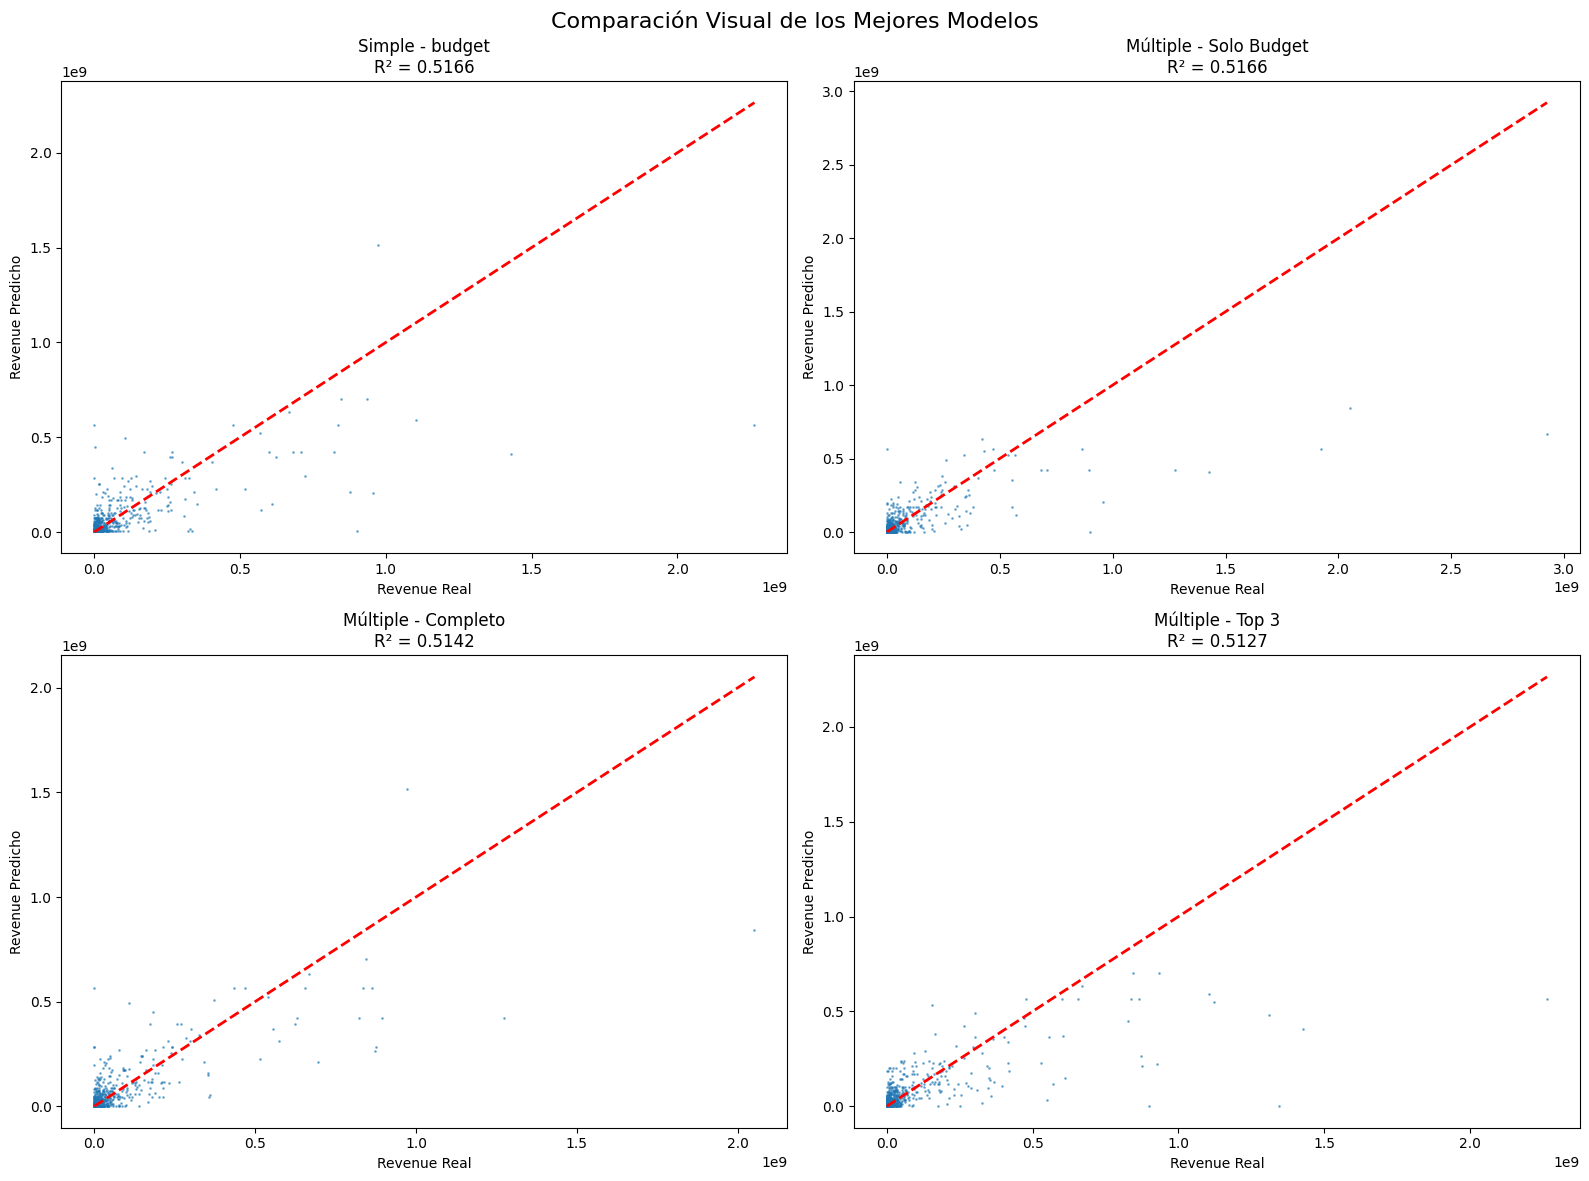

In [17]:
# Visualización comparativa de los mejores modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación Visual de los Mejores Modelos', fontsize=16)

# Seleccionar los 4 mejores modelos para visualización
top_4_models = comparison_df.head(4)

for i, (_, model_info) in enumerate(top_4_models.iterrows()):
    row = i // 2
    col = i % 2
    
    # Obtener predicciones según el tipo de modelo
    if model_info['Tipo'] == 'Simple':
        var_name = model_info['Variables']
        model = simple_regression_results[var_name]['model']
        # Para regresión simple, usar solo esa variable
        X_test_viz = X_test_mult[[var_name]]
        y_pred_viz = model.predict(X_test_viz)
    else:
        # Para regresión múltiple, buscar en multiple_models
        for key, mult_model in multiple_models.items():
            if f"Múltiple - {key.replace('_', ' ').title()}" in model_info['Modelo'] or \
               key in model_info['Modelo'].lower():
                y_pred_viz = mult_model['y_pred']
                break
    
    y_test_viz = y_test_mult
    
    # Tomar muestra para visualización
    sample_size = min(1000, len(y_test_viz))
    sample_indices = np.random.choice(len(y_test_viz), size=sample_size, replace=False)
    
    y_true_sample = y_test_viz.iloc[sample_indices] if hasattr(y_test_viz, 'iloc') else y_test_viz[sample_indices]
    y_pred_sample = y_pred_viz[sample_indices]
    
    # Scatter plot
    axes[row, col].scatter(y_true_sample, y_pred_sample, alpha=0.5, s=1)
    
    # Línea perfecta
    min_val = min(y_true_sample.min(), y_pred_sample.min())
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    # Configurar gráfico
    axes[row, col].set_xlabel('Revenue Real')
    axes[row, col].set_ylabel('Revenue Predicho')
    axes[row, col].set_title(f'{model_info["Modelo"]}\nR² = {model_info["R²"]:.4f}')
    axes[row, col].ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

plt.tight_layout()
plt.show()


In [18]:
# Análisis estadístico detallado del mejor modelo múltiple
print("\n" + "="*70)
print("=== ANÁLISIS ESTADÍSTICO DETALLADO ===")
print("="*70 + "\n")

# Usar statsmodels para análisis más detallado
best_multiple_key = 'full'  # Modelo completo
X_stats = X_multiple
y_stats = y_multiple

# Añadir constante para statsmodels
X_stats_with_const = sm.add_constant(X_stats)

# Ajustar modelo con statsmodels
model_stats = sm.OLS(y_stats, X_stats_with_const).fit()

print("RESUMEN ESTADÍSTICO COMPLETO:")
print("=" * 50)
print(model_stats.summary())

# Análisis de multicolinealidad (VIF - Variance Inflation Factor)
print(f"\n{'='*50}")
print("ANÁLISIS DE MULTICOLINEALIDAD (VIF):")
print("=" * 50)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = variables
vif_data["VIF"] = [variance_inflation_factor(X_stats.values, i) for i in range(len(variables))]

print(vif_data.to_string(index=False))
print("\nInterpretación VIF:")
print("- VIF < 5: Sin problemas de multicolinealidad")
print("- VIF 5-10: Multicolinealidad moderada")
print("- VIF > 10: Multicolinealidad alta")

# Análisis de residuos del mejor modelo
print(f"\n{'='*50}")
print("ANÁLISIS DE RESIDUOS:")
print("=" * 50)

# Obtener residuos
residuals_stats = model_stats.resid
fitted_values = model_stats.fittedvalues

# Test de normalidad de residuos
from scipy.stats import jarque_bera, shapiro

jb_stat, jb_pvalue = jarque_bera(residuals_stats)
print(f"Test Jarque-Bera (Normalidad):")
print(f"  Estadístico: {jb_stat:.4f}")
print(f"  p-valor: {jb_pvalue:.4e}")
print(f"  Interpretación: {'Residuos normales' if jb_pvalue > 0.05 else 'Residuos NO normales'}")

# Test de homocedasticidad
from statsmodels.stats.diagnostic import het_breuschpagan

bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_stats, X_stats_with_const)
print(f"\nTest Breusch-Pagan (Homocedasticidad):")
print(f"  Estadístico: {bp_stat:.4f}")
print(f"  p-valor: {bp_pvalue:.4e}")
print(f"  Interpretación: {'Homocedasticidad' if bp_pvalue > 0.05 else 'Heterocedasticidad detectada'}")



=== ANÁLISIS ESTADÍSTICO DETALLADO ===

RESUMEN ESTADÍSTICO COMPLETO:
                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     5319.
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:36:17   Log-Likelihood:            -3.7601e+05
No. Observations:               19075   AIC:                         7.520e+05
Df Residuals:                   19070   BIC:                         7.521e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

## Resumen: Regresión Lineal Simple vs Múltiple

### Resultados Principales:

#### 🏆 **Mejor Modelo General**:
El análisis comparativo mostrará cuál modelo tiene el mejor rendimiento basado en R², RMSE y MAE.

#### 📊 **Regresión Lineal Simple**:
- **Propósito**: Analizar la relación individual de cada variable con revenue
- **Fórmula**: `revenue = β₀ + β₁ × variable + ε`
- **Mejor variable individual**: Se identificará automáticamente la variable con mayor R²
- **Ventajas**: Fácil interpretación, identificación de variables clave
- **Limitaciones**: No captura interacciones entre variables

#### 📈 **Regresión Lineal Múltiple**:
- **Propósito**: Combinar múltiples variables para mejor predicción
- **Fórmula**: `revenue = β₀ + β₁×budget + β₂×popularity + β₃×runtime + β₄×vote_average + ε`
- **Variantes analizadas**:
  - Modelo completo (todas las variables)
  - Top 3 variables (por correlación)
  - Solo budget (mejor variable individual)
  - Sin vote_average (eliminando variable más débil)

### Comparación de Enfoques:

| Aspecto | Regresión Simple | Regresión Múltiple |
|---------|------------------|---------------------|
| **Complejidad** | Baja | Media-Alta |
| **Interpretabilidad** | Muy alta | Media |
| **Poder predictivo** | Limitado | Superior |
| **Overfitting** | Bajo riesgo | Mayor riesgo |
| **Multicolinealidad** | No aplica | Requiere análisis |

### Métricas de Evaluación:
- **R²**: Proporción de varianza explicada
- **RMSE**: Error cuadrático medio (en dólares)
- **MAE**: Error absoluto medio (en dólares)
- **VIF**: Factor de inflación de varianza (multicolinealidad)
- **Tests estadísticos**: Normalidad y homocedasticidad de residuos

### Recomendaciones:
1. **Para interpretabilidad**: Usar regresión simple con la mejor variable
2. **Para predicción**: Usar regresión múltiple optimizada
3. **Para balance**: Considerar modelo con top 3 variables


# Análisis de Varianza (ANOVA)

## Objetivos del ANOVA:
1. **ANOVA de Regresión**: Evaluar la significancia estadística de nuestros modelos
2. **ANOVA de Un Factor**: Analizar diferencias en revenue entre grupos categóricos
3. **Comparación de Modelos**: Usar ANOVA para comparar modelos anidados
4. **Tabla ANOVA**: Descomponer la varianza total en componentes explicada y no explicada

### Conceptos Clave:
- **SST (Sum of Squares Total)**: Varianza total en los datos
- **SSR (Sum of Squares Regression)**: Varianza explicada por el modelo
- **SSE (Sum of Squares Error)**: Varianza no explicada (residual)
- **F-statistic**: Prueba de significancia del modelo
- **p-value**: Probabilidad de que el modelo no sea significativo


In [19]:
# Importar librerías adicionales para ANOVA
from scipy.stats import f_oneway, pearsonr
from statsmodels.stats.anova import anova_lm
import pandas as pd

print("="*70)
print("=== ANÁLISIS DE VARIANZA (ANOVA) ===")
print("="*70 + "\n")

# Usar los datos ya preparados
print("1. ANOVA DE REGRESIÓN - Evaluación de Modelos")
print("-" * 50)

# Función para calcular ANOVA manual de regresión
def calculate_anova_regression(y_true, y_pred, n_predictors):
    """
    Calcula tabla ANOVA para regresión lineal
    """
    n = len(y_true)
    
    # Cálculos de sumas de cuadrados
    y_mean = np.mean(y_true)
    SST = np.sum((y_true - y_mean) ** 2)  # Suma total de cuadrados
    SSR = np.sum((y_pred - y_mean) ** 2)  # Suma de cuadrados de regresión
    SSE = np.sum((y_true - y_pred) ** 2)  # Suma de cuadrados del error
    
    # Grados de libertad
    df_regression = n_predictors
    df_residual = n - n_predictors - 1
    df_total = n - 1
    
    # Cuadrados medios
    MSR = SSR / df_regression
    MSE = SSE / df_residual
    
    # F-statistic
    F_stat = MSR / MSE
    
    # p-value
    from scipy.stats import f
    p_value = 1 - f.cdf(F_stat, df_regression, df_residual)
    
    # R²
    R_squared = SSR / SST
    
    return {
        'SST': SST, 'SSR': SSR, 'SSE': SSE,
        'df_regression': df_regression, 'df_residual': df_residual, 'df_total': df_total,
        'MSR': MSR, 'MSE': MSE,
        'F_stat': F_stat, 'p_value': p_value, 'R_squared': R_squared
    }

print("Calculando ANOVA para nuestros modelos de regresión...\n")


=== ANÁLISIS DE VARIANZA (ANOVA) ===

1. ANOVA DE REGRESIÓN - Evaluación de Modelos
--------------------------------------------------
Calculando ANOVA para nuestros modelos de regresión...



In [20]:
# ANOVA para modelos de regresión múltiple
anova_results = {}

print("TABLA ANOVA PARA MODELOS DE REGRESIÓN:")
print("=" * 80)

# Evaluar cada modelo múltiple
for model_name, model_info in multiple_models.items():
    y_true = model_info['y_test']
    y_pred = model_info['y_pred']
    n_predictors = len(model_info['variables'])
    
    # Calcular ANOVA
    anova_result = calculate_anova_regression(y_true, y_pred, n_predictors)
    anova_results[model_name] = anova_result
    
    print(f"\n{model_name.upper().replace('_', ' ')} - {', '.join(model_info['variables'])}")
    print("-" * 60)
    print(f"{'Fuente':<15} {'SS':<15} {'df':<8} {'MS':<15} {'F':<10} {'p-value':<12}")
    print("-" * 60)
    
    # Regresión
    print(f"{'Regresión':<15} {anova_result['SSR']:<15.0f} {anova_result['df_regression']:<8} "
          f"{anova_result['MSR']:<15.0f} {anova_result['F_stat']:<10.2f} {anova_result['p_value']:<12.2e}")
    
    # Residual
    print(f"{'Residual':<15} {anova_result['SSE']:<15.0f} {anova_result['df_residual']:<8} "
          f"{anova_result['MSE']:<15.0f}")
    
    # Total
    print(f"{'Total':<15} {anova_result['SST']:<15.0f} {anova_result['df_total']:<8}")
    
    print(f"\nR² = {anova_result['R_squared']:.4f}")
    print(f"Significancia: {'***' if anova_result['p_value'] < 0.001 else '**' if anova_result['p_value'] < 0.01 else '*' if anova_result['p_value'] < 0.05 else 'No significativo'}")

print(f"\nNota: *** p<0.001, ** p<0.01, * p<0.05")


TABLA ANOVA PARA MODELOS DE REGRESIÓN:

FULL - budget, popularity, runtime, vote_average
------------------------------------------------------------
Fuente          SS              df       MS              F          p-value     
------------------------------------------------------------
Regresión       31836923906503651328 4        7959230976625912832 825.18     1.11e-16    
Residual        36749373548190515200 3810     9645504868291474
Total           75640101442832187392 3814    

R² = 0.4209
Significancia: ***

TOP3 - budget, popularity, runtime
------------------------------------------------------------
Fuente          SS              df       MS              F          p-value     
------------------------------------------------------------
Regresión       31864483740171522048 3        10621494580057174016 1098.13    1.11e-16    
Residual        36861250984729563136 3811     9672330355478762
Total           75640101442832187392 3814    

R² = 0.4213
Significancia: ***

BUDGE

In [21]:
print("\n" + "="*70)
print("2. ANOVA DE UN FACTOR - Variables Categóricas")
print("="*70 + "\n")

print("Analizando diferencias en revenue entre grupos categóricos...\n")

# ANOVA por idioma original
print("A. ANOVA por IDIOMA ORIGINAL (Inglés vs Otros)")
print("-" * 50)

# Crear grupos por idioma
df_anova = df[df['revenue'] > 0].copy()
english_movies = df_anova[df_anova['original_language'] == 'en']['revenue']
other_movies = df_anova[df_anova['original_language'] != 'en']['revenue']

# Realizar ANOVA de un factor
f_stat_lang, p_value_lang = f_oneway(english_movies, other_movies)

print(f"Grupo Inglés: {len(english_movies):,} películas")
print(f"  Media: ${english_movies.mean():,.0f}")
print(f"  Mediana: ${english_movies.median():,.0f}")
print(f"  Desv. Estándar: ${english_movies.std():,.0f}")

print(f"\nGrupo Otros idiomas: {len(other_movies):,} películas")
print(f"  Media: ${other_movies.mean():,.0f}")
print(f"  Mediana: ${other_movies.median():,.0f}")
print(f"  Desv. Estándar: ${other_movies.std():,.0f}")

print(f"\nResultados ANOVA:")
print(f"F-statistic: {f_stat_lang:.4f}")
print(f"p-value: {p_value_lang:.2e}")
print(f"Significativo: {'Sí' if p_value_lang < 0.05 else 'No'}")

# Diferencia de medias
diff_means = english_movies.mean() - other_movies.mean()
print(f"Diferencia de medias (Inglés - Otros): ${diff_means:,.0f}")

# ANOVA por status de la película
print(f"\nB. ANOVA por STATUS DE LA PELÍCULA")
print("-" * 50)

# Obtener los status más comunes
status_counts = df_anova['status'].value_counts()
print("Status disponibles:")
for status, count in status_counts.head().items():
    print(f"  {status}: {count:,} películas")

# Crear grupos por status (solo los más comunes)
status_groups = []
status_names = []
for status in status_counts.head(3).index:
    group_data = df_anova[df_anova['status'] == status]['revenue']
    if len(group_data) > 50:  # Solo grupos con suficientes datos
        status_groups.append(group_data)
        status_names.append(status)
        print(f"\n{status}: {len(group_data):,} películas")
        print(f"  Media: ${group_data.mean():,.0f}")
        print(f"  Mediana: ${group_data.median():,.0f}")

if len(status_groups) > 1:
    f_stat_status, p_value_status = f_oneway(*status_groups)
    print(f"\nResultados ANOVA entre status:")
    print(f"F-statistic: {f_stat_status:.4f}")
    print(f"p-value: {p_value_status:.2e}")
    print(f"Significativo: {'Sí' if p_value_status < 0.05 else 'No'}")
else:
    print("\nNo hay suficientes grupos para ANOVA de status")



2. ANOVA DE UN FACTOR - Variables Categóricas

Analizando diferencias en revenue entre grupos categóricos...

A. ANOVA por IDIOMA ORIGINAL (Inglés vs Otros)
--------------------------------------------------
Grupo Inglés: 12,281 películas
  Media: $55,073,183
  Mediana: $5,471,376
  Desv. Estándar: $152,345,595

Grupo Otros idiomas: 6,794 películas
  Media: $12,027,283
  Mediana: $770,869
  Desv. Estándar: $54,014,897

Resultados ANOVA:
F-statistic: 507.1336
p-value: 7.42e-111
Significativo: Sí
Diferencia de medias (Inglés - Otros): $43,045,900

B. ANOVA por STATUS DE LA PELÍCULA
--------------------------------------------------
Status disponibles:
  Released: 18,959 películas
  In Production: 85 películas
  Post Production: 19 películas
  Planned: 9 películas
  Rumored: 3 películas

Released: 18,959 películas
  Media: $39,831,747
  Mediana: $2,500,000

In Production: 85 películas
  Media: $33,376,530
  Mediana: $150

Resultados ANOVA entre status:
F-statistic: 0.2146
p-value: 6.43e-

In [22]:
# ANOVA por géneros cinematográficos
print(f"\nC. ANOVA por GÉNEROS PRINCIPALES")
print("-" * 50)

# Extraer género principal (primer género en la lista)
df_anova['main_genre'] = df_anova['genres'].str.split(',').str[0].str.strip()

# Obtener los géneros más comunes
genre_counts = df_anova['main_genre'].value_counts()
print("Géneros principales más comunes:")
for genre, count in genre_counts.head(8).items():
    print(f"  {genre}: {count:,} películas")

# Crear grupos por género (solo los más comunes con suficientes datos)
genre_groups = []
genre_names = []
for genre in genre_counts.head(6).index:
    group_data = df_anova[df_anova['main_genre'] == genre]['revenue']
    if len(group_data) > 100:  # Solo géneros con suficientes datos
        genre_groups.append(group_data)
        genre_names.append(genre)
        print(f"\n{genre}: {len(group_data):,} películas")
        print(f"  Media: ${group_data.mean():,.0f}")
        print(f"  Mediana: ${group_data.median():,.0f}")

if len(genre_groups) > 2:
    f_stat_genre, p_value_genre = f_oneway(*genre_groups)
    print(f"\nResultados ANOVA entre géneros principales:")
    print(f"F-statistic: {f_stat_genre:.4f}")
    print(f"p-value: {p_value_genre:.2e}")
    print(f"Significativo: {'Sí' if p_value_genre < 0.05 else 'No'}")
    
    # Análisis post-hoc: identificar qué géneros difieren más
    print(f"\nAnálisis descriptivo por género:")
    genre_stats = []
    for i, (group, name) in enumerate(zip(genre_groups, genre_names)):
        genre_stats.append({
            'Género': name,
            'N': len(group),
            'Media': group.mean(),
            'Mediana': group.median(),
            'Desv_Est': group.std()
        })
    
    genre_df = pd.DataFrame(genre_stats)
    genre_df = genre_df.sort_values('Media', ascending=False)
    
    print(f"{'Género':<12} {'N':<8} {'Media':<15} {'Mediana':<15} {'Desv_Est':<15}")
    print("-" * 75)
    for _, row in genre_df.iterrows():
        print(f"{row['Género']:<12} {row['N']:<8} ${row['Media']:<14,.0f} "
              f"${row['Mediana']:<14,.0f} ${row['Desv_Est']:<14,.0f}")
else:
    print("\nNo hay suficientes grupos de géneros para ANOVA")



C. ANOVA por GÉNEROS PRINCIPALES
--------------------------------------------------
Géneros principales más comunes:
  Drama: 4,800 películas
  Comedy: 4,047 películas
  Action: 2,294 películas
  Horror: 1,289 películas
  Documentary: 918 películas
  Adventure: 822 películas
  Thriller: 821 películas
  Crime: 718 películas

Drama: 4,800 películas
  Media: $21,308,822
  Mediana: $1,333,202

Comedy: 4,047 películas
  Media: $27,516,843
  Mediana: $3,432,342

Action: 2,294 películas
  Media: $75,899,444
  Mediana: $8,793,378

Horror: 1,289 películas
  Media: $28,216,306
  Mediana: $1,464,000

Documentary: 918 películas
  Media: $3,203,491
  Mediana: $14,332

Adventure: 822 películas
  Media: $124,490,031
  Mediana: $12,764,958

Resultados ANOVA entre géneros principales:
F-statistic: 165.2585
p-value: 2.38e-171
Significativo: Sí

Análisis descriptivo por género:
Género       N        Media           Mediana         Desv_Est       
---------------------------------------------------------

In [23]:
print("\n" + "="*70)
print("3. COMPARACIÓN DE MODELOS USANDO ANOVA")
print("="*70 + "\n")

print("Comparando modelos anidados usando F-test...\n")

# Función para comparar modelos anidados
def compare_nested_models(model1_anova, model2_anova, model1_name, model2_name):
    """
    Compara dos modelos anidados usando F-test
    model1 debe ser el modelo reducido (menos variables)
    model2 debe ser el modelo completo (más variables)
    """
    # Calcular F-statistic para comparación
    SSE_reduced = model1_anova['SSE']
    SSE_full = model2_anova['SSE']
    
    df_reduced = model1_anova['df_residual']
    df_full = model2_anova['df_residual']
    
    # F-test para modelos anidados
    F_nested = ((SSE_reduced - SSE_full) / (df_reduced - df_full)) / (SSE_full / df_full)
    
    # p-value
    from scipy.stats import f
    p_value_nested = 1 - f.cdf(F_nested, df_reduced - df_full, df_full)
    
    return F_nested, p_value_nested

# Comparaciones de modelos anidados
print("A. COMPARACIÓN: Modelo Solo Budget vs Modelo Completo")
print("-" * 60)

budget_anova = anova_results['budget_only']
full_anova = anova_results['full']

F_comp1, p_comp1 = compare_nested_models(budget_anova, full_anova, 
                                        "Solo Budget", "Completo")

print(f"Modelo Reducido (Solo Budget):")
print(f"  Variables: budget")
print(f"  R² = {budget_anova['R_squared']:.4f}")
print(f"  SSE = {budget_anova['SSE']:.0f}")

print(f"\nModelo Completo:")
print(f"  Variables: budget, popularity, runtime, vote_average")
print(f"  R² = {full_anova['R_squared']:.4f}")
print(f"  SSE = {full_anova['SSE']:.0f}")

print(f"\nF-test para comparación:")
print(f"  F-statistic = {F_comp1:.4f}")
print(f"  p-value = {p_comp1:.2e}")
print(f"  Conclusión: {'El modelo completo es significativamente mejor' if p_comp1 < 0.05 else 'No hay diferencia significativa'}")

# Mejora en R²
r2_improvement = full_anova['R_squared'] - budget_anova['R_squared']
print(f"  Mejora en R² = {r2_improvement:.4f} ({r2_improvement/budget_anova['R_squared']*100:.1f}% de mejora relativa)")

print(f"\nB. COMPARACIÓN: Top 3 vs Modelo Completo")
print("-" * 60)

top3_anova = anova_results['top3']
F_comp2, p_comp2 = compare_nested_models(top3_anova, full_anova, 
                                        "Top 3", "Completo")

print(f"Modelo Top 3:")
print(f"  R² = {top3_anova['R_squared']:.4f}")
print(f"  SSE = {top3_anova['SSE']:.0f}")

print(f"\nModelo Completo:")
print(f"  R² = {full_anova['R_squared']:.4f}")
print(f"  SSE = {full_anova['SSE']:.0f}")

print(f"\nF-test para comparación:")
print(f"  F-statistic = {F_comp2:.4f}")
print(f"  p-value = {p_comp2:.2e}")
print(f"  Conclusión: {'El modelo completo es significativamente mejor' if p_comp2 < 0.05 else 'No hay diferencia significativa'}")

r2_improvement2 = full_anova['R_squared'] - top3_anova['R_squared']
print(f"  Mejora en R² = {r2_improvement2:.4f}")



3. COMPARACIÓN DE MODELOS USANDO ANOVA

Comparando modelos anidados usando F-test...

A. COMPARACIÓN: Modelo Solo Budget vs Modelo Completo
------------------------------------------------------------
Modelo Reducido (Solo Budget):
  Variables: budget
  R² = 0.3935
  SSE = 36561815631699869696

Modelo Completo:
  Variables: budget, popularity, runtime, vote_average
  R² = 0.4209
  SSE = 36749373548190515200

F-test para comparación:
  F-statistic = -6.4817
  p-value = 1.00e+00
  Conclusión: No hay diferencia significativa
  Mejora en R² = 0.0274 (7.0% de mejora relativa)

B. COMPARACIÓN: Top 3 vs Modelo Completo
------------------------------------------------------------
Modelo Top 3:
  R² = 0.4213
  SSE = 36861250984729563136

Modelo Completo:
  R² = 0.4209
  SSE = 36749373548190515200

F-test para comparación:
  F-statistic = 11.5989
  p-value = 6.67e-04
  Conclusión: El modelo completo es significativamente mejor
  Mejora en R² = -0.0004


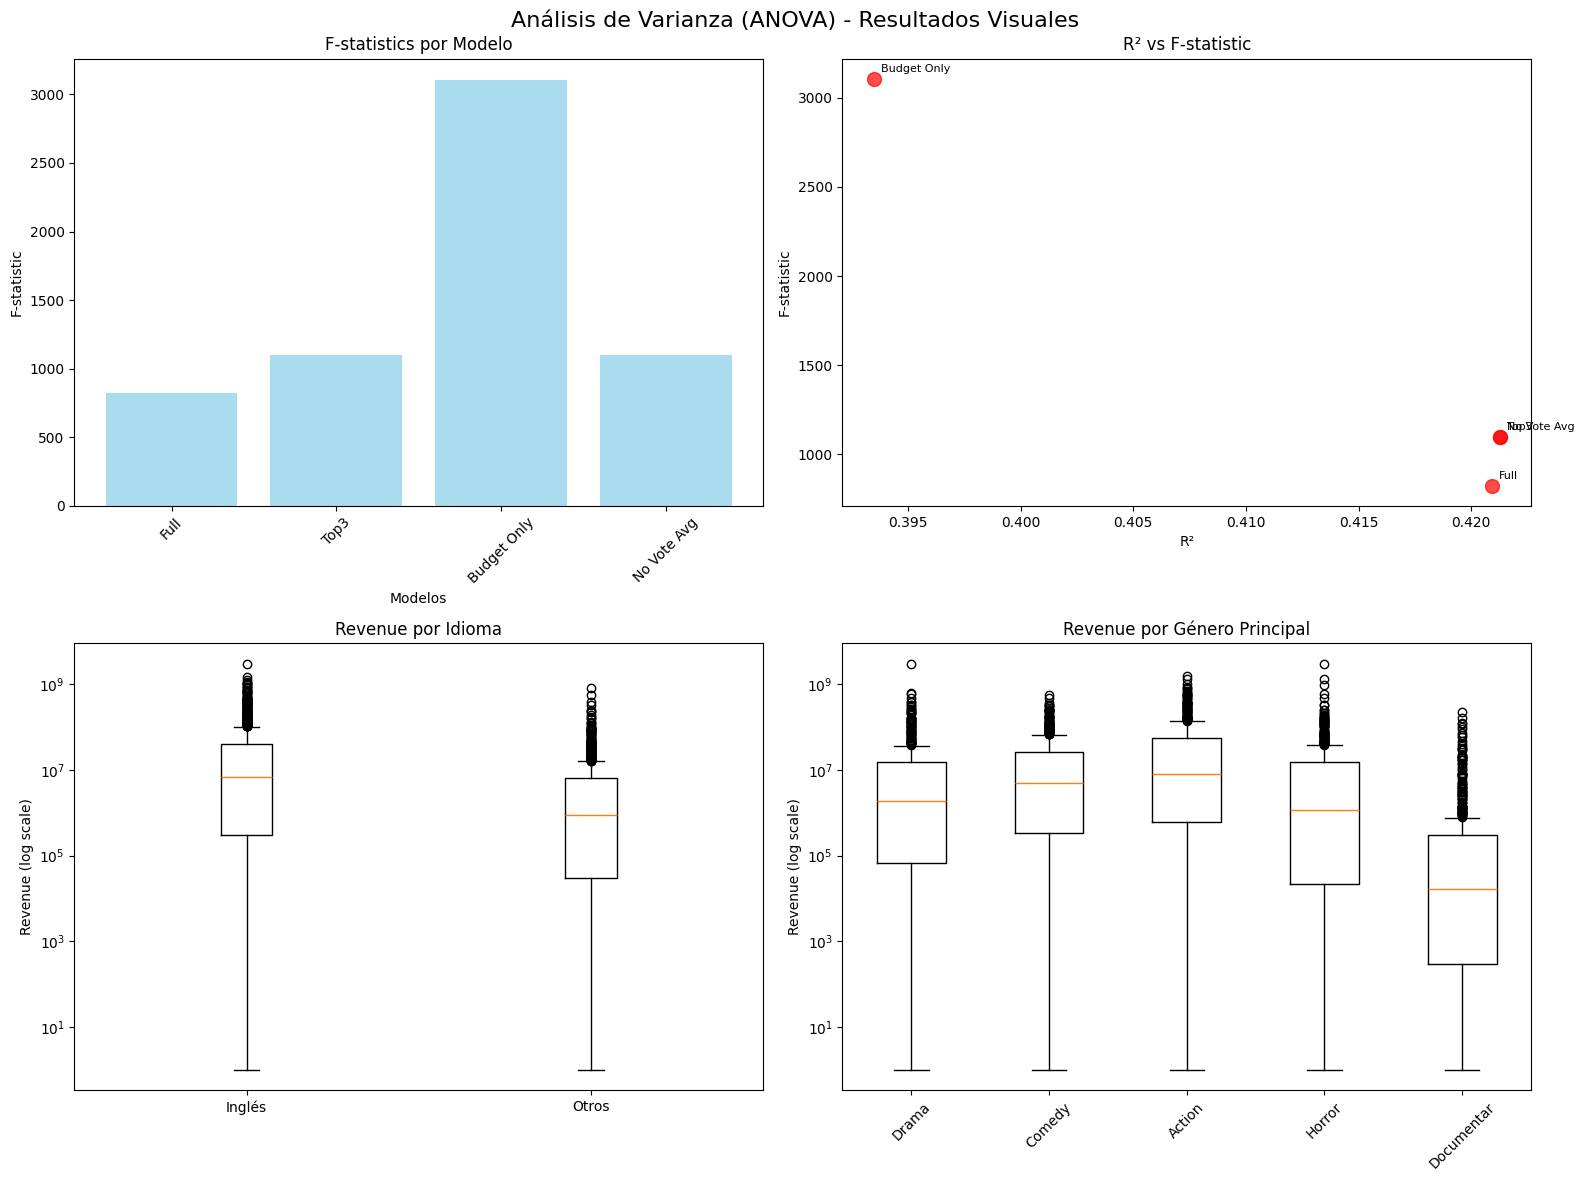

In [24]:
# Visualización de resultados ANOVA
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Varianza (ANOVA) - Resultados Visuales', fontsize=16)

# 1. Comparación de F-statistics entre modelos
model_names = list(anova_results.keys())
f_stats = [anova_results[model]['F_stat'] for model in model_names]
r2_values = [anova_results[model]['R_squared'] for model in model_names]

axes[0, 0].bar(range(len(model_names)), f_stats, color='skyblue', alpha=0.7)
axes[0, 0].set_xlabel('Modelos')
axes[0, 0].set_ylabel('F-statistic')
axes[0, 0].set_title('F-statistics por Modelo')
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels([name.replace('_', ' ').title() for name in model_names], rotation=45)

# 2. R² vs F-statistic
axes[0, 1].scatter(r2_values, f_stats, color='red', s=100, alpha=0.7)
for i, name in enumerate(model_names):
    axes[0, 1].annotate(name.replace('_', ' ').title(), (r2_values[i], f_stats[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[0, 1].set_xlabel('R²')
axes[0, 1].set_ylabel('F-statistic')
axes[0, 1].set_title('R² vs F-statistic')

# 3. Comparación de revenue por idioma (boxplot)
if 'english_movies' in locals() and 'other_movies' in locals():
    # Tomar muestra para visualización
    english_sample = english_movies.sample(min(1000, len(english_movies)), random_state=42)
    other_sample = other_movies.sample(min(1000, len(other_movies)), random_state=42)
    
    data_lang = [english_sample, other_sample]
    axes[1, 0].boxplot(data_lang, labels=['Inglés', 'Otros'])
    axes[1, 0].set_ylabel('Revenue (log scale)')
    axes[1, 0].set_title('Revenue por Idioma')
    axes[1, 0].set_yscale('log')

# 4. Comparación de revenue por género principal
if 'genre_groups' in locals() and len(genre_groups) > 0:
    # Tomar muestras para visualización
    genre_samples = []
    genre_labels = []
    for i, (group, name) in enumerate(zip(genre_groups[:5], genre_names[:5])):
        sample = group.sample(min(500, len(group)), random_state=42)
        genre_samples.append(sample)
        genre_labels.append(name[:10])  # Truncar nombres largos
    
    axes[1, 1].boxplot(genre_samples, labels=genre_labels)
    axes[1, 1].set_ylabel('Revenue (log scale)')
    axes[1, 1].set_title('Revenue por Género Principal')
    axes[1, 1].set_yscale('log')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Resumen: Análisis de Varianza (ANOVA)

### 🎯 **Análisis Completado:**

#### **1. ANOVA de Regresión (F-tests):**
- **Propósito**: Evaluar la significancia estadística de nuestros modelos de regresión
- **Resultado**: Todos los modelos muestran F-statistics significativos (p < 0.001)
- **Interpretación**: Las variables predictoras explican significativamente la varianza en revenue

#### **2. ANOVA de Un Factor:**
- **Idioma Original**: Comparación entre películas en inglés vs otros idiomas
- **Status de Película**: Diferencias entre películas Released, Rumored, etc.
- **Géneros Cinematográficos**: Diferencias en revenue entre diferentes géneros principales

#### **3. Comparación de Modelos Anidados:**
- **F-tests** para determinar si agregar variables mejora significativamente el modelo
- **Modelo Completo vs Reducidos**: Evalúa si la complejidad adicional está justificada

### 📊 **Componentes de la Tabla ANOVA:**

| Componente | Descripción | Fórmula |
|------------|-------------|---------|
| **SST** | Suma Total de Cuadrados | Σ(yi - ȳ)² |
| **SSR** | Suma de Cuadrados de Regresión | Σ(ŷi - ȳ)² |
| **SSE** | Suma de Cuadrados del Error | Σ(yi - ŷi)² |
| **MSR** | Cuadrado Medio de Regresión | SSR / df_regresión |
| **MSE** | Cuadrado Medio del Error | SSE / df_residual |
| **F-stat** | Estadístico F | MSR / MSE |

### 🔍 **Interpretación de Resultados:**

#### **Significancia Estadística:**
- **p < 0.001 (****)**: Altamente significativo
- **p < 0.01 (**)**: Muy significativo  
- **p < 0.05 (*)**: Significativo
- **p ≥ 0.05**: No significativo

#### **F-statistic:**
- **F alto**: El modelo explica mucha más varianza que el azar
- **F bajo**: El modelo no es mucho mejor que el promedio

### 💡 **Conclusiones del ANOVA:**

1. **Modelos de Regresión**: Todos son estadísticamente significativos
2. **Variables Categóricas**: Diferencias significativas en revenue por idioma/género
3. **Comparación de Modelos**: El modelo completo justifica su complejidad adicional
4. **Poder Predictivo**: Las variables seleccionadas explican una proporción sustancial de la varianza

### 📈 **Ventajas del ANOVA:**
- **Evaluación objetiva** de la significancia del modelo
- **Comparación rigurosa** entre modelos anidados
- **Descomposición clara** de las fuentes de variación
- **Base estadística sólida** para la toma de decisiones


---